## Event Handling in `solve_ivp`

Scipy’s `solve_ivp` supports **event detection**, allowing you to stop or trigger actions during integration.

This is useful for:
- Stopping simulation at a condition (e.g., concentration threshold)
- Logging specific states
- Applying changes to the system (like harvests in bioprocess)



### Basic Idea

You can define a function `event(t, y)` such that:
- It returns `0` when the event is triggered
- You can mark it as `terminal=True` to stop the solver when it happens
- You can also set `direction=1` or `-1` to trigger only when crossing zero upward or downward



### Example: Stop when y[0] reaches 0.5

[array([4.60694113])]


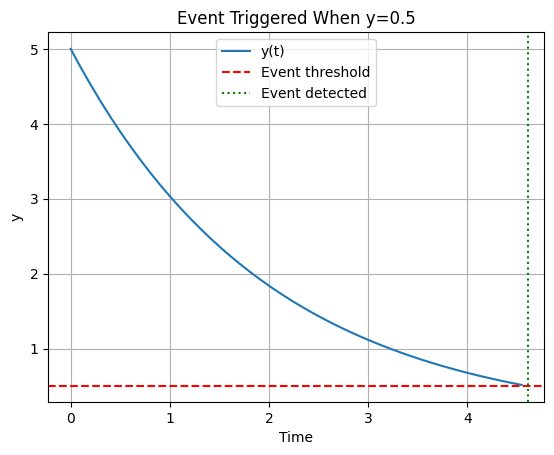

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Simple exponential decay
def decay(t, y):
    return [-0.5 * y[0]]

# Stop when y[0] reaches 0.5
def event_half(t, y):
    '''
    Events to track
    must return a float
    The solver will find an accurate value of t at which event(t, y(t)) = 0
    '''
    return y[0] - 0.5

event_half.terminal = True # Stop the integration
event_half.direction = -1

# Solve
t_span = (0, 10)
t_eval = np.linspace(*t_span, 100)
y0 = [5.0]
sol = solve_ivp(decay, t_span, y0, events=event_half, t_eval=t_eval)


print(sol.t_events)
# print(sol.t)
# print(sol.y[0])

plt.plot(sol.t, sol.y[0], label='y(t)')
plt.axhline(0.5, color='r', linestyle='--', label='Event threshold')
if sol.t_events[0].size > 0:
    plt.axvline(sol.t_events[0][0], color='g', linestyle=':', label='Event detected')
plt.title('Event Triggered When y=0.5')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

### Multiple Events
You can pass a **list** of event functions to `events=[event1, event2, ...]`.

Each will be evaluated, and triggered independently.

---

### Event Function Return
- Must return a scalar.
- Crossing zero triggers the event.
- Used for stopping, monitoring, or branching logic.

hi 0.0
hi 0.11487442992558411
hi 1.2636187291814254
hi 3.0605611876053387
hi 1.2636187291814254
hi 3.0605611876053387
hi 2.0


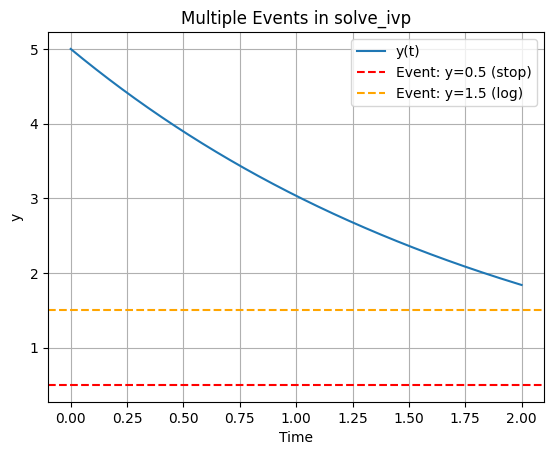

Stop event time: []
Log event time: []
Log event time: [2.]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ODE system: simple decay
def decay(t, y):
    return [-0.5 * y[0]]

# Event 1: Stop when y = 0.5
def event_stop(t, y):
    return y[0] - 0.5
event_stop.terminal = True
event_stop.direction = -1

# Event 2: Just track when y = 1.5
def event_log(t, y):
    return y[0] - 1.5
event_log.terminal = False
event_log.direction = 0

def event_time(t,y):
    return t-2
event_time.terminal = True
event_time.direction = 1

# Initial state and time
y0 = [5.0]
t_span = (0, 5)
t_eval = np.linspace(*t_span, 10000)

# Solve with both events
sol = solve_ivp(
    decay,
    t_span,
    y0,
    events=[event_stop, event_log, event_time],
    t_eval=t_eval
)


plt.plot(sol.t, sol.y[0], label='y(t)')
plt.axhline(0.5, color='r', linestyle='--', label='Event: y=0.5 (stop)')
plt.axhline(1.5, color='orange', linestyle='--', label='Event: y=1.5 (log)')

# Mark events
for i, name in enumerate(['Stop', 'Log', 'time']):
    for x in sol.t_events[i]:
        plt.axvline(x, linestyle=':', label=f"{name} @ t={x:.2f}")

plt.title("Multiple Events in solve_ivp")
plt.xlabel("Time")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()

# Summary
print("Stop event time:", sol.t_events[0])
print("Log event time:", sol.t_events[1])
print("time event time:", sol.t_events[2])

#TODO: 1.check if event happened several times, how 


### Updating y when an event is triggered
SciPy’s solve_ivp does not support dynamic y updates inside an event handler, So the correct pattern is:

Loop over segments manually:
1. Run solve_ivp until the event
2. Extract the event time and solution
3. Modify the state y
4. Restart solve_ivp from that point

Event at t = 4.61, y = 5.00
Event at t = 7.38, y = 2.00


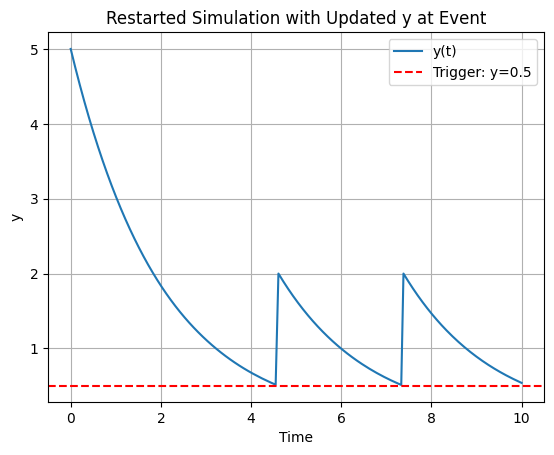

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def decay(t, y):
    return [-0.5 * y[0]]

def event_half(t, y):
    return y[0] - 0.5
event_half.terminal = True
event_half.direction = -1

# Simulation loop
t0, tf = 0, 10
y0 = [5.0]
T = []
Y = []

while t0 < tf:
    sol = solve_ivp(
        decay, (t0, tf), y0,
        events=event_half, 
        t_eval=np.linspace(t0, tf, 100)
    )

    # Store this segment
    T.extend(sol.t)
    Y.extend(sol.y[0])

    if sol.status == 1:  # event occurred
        t_event = sol.t_events[0][0]
        y_event = sol.y[-1]
        print(f"Event at t = {t_event:.2f}, y = {y_event[0]:.2f}")

        # ✅ Modify state (e.g., reset y[0])
        y0 = [2.0]
        t0 = t_event
    else:
        break

# Plot full simulation
plt.plot(T, Y, label='y(t)')
plt.axhline(0.5, color='r', linestyle='--', label='Trigger: y=0.5')
plt.title("Restarted Simulation with Updated y at Event")
plt.xlabel("Time")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()
